In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [53]:
# Define the model
class FiniteDifferenceOperator(nn.Module):
    def __init__(self,Nleft,Nright,dx):
        super(FiniteDifferenceOperator, self).__init__()
        # Number of total nodes in finite difference stencils
        self.Nstencil = Nleft + Nright + 1
        self.Nleft = Nleft
        self.Nright = Nright

        # Define a learnable finite difference stencil with zero sum

        self.stencil1 = torch.nn.Parameter(0.9*torch.tensor([1.0,-1.0,0.0],dtype=torch.float64)[:-1])
        self.stencil2 = -self.stencil1.sum()
        self.stencil = torch.cat((self.stencil1, self.stencil2.unsqueeze(0)))
   
        self.h = dx

    def forward(self, xx):
        # Apply the finite difference stencil to the gridfunction x, assuming periodic BC
        N_nodes = xx.shape[0]
        xx[-1] = xx[0]
        # Goal - build up D^* grad(N[D x])

        # Step 1 - apply D stencil to x 
        Dh_x = torch.zeros_like(x)
        for i in range(N_nodes-1):
          # Wrap indices periodically using the modulo operator (%)
          indices = [(i + j - self.Nleft) % (N_nodes-1) for j in range(self.Nstencil)]
          # print(i,indices)
          # print(self.stencil)
          # print(torch.flip(self.stencil,[0]))
          # Grab solution at indices
          xstencil = xx[indices]
          # print(xstencil)
          # Apply learned stencil to xstencil
          Dh_x[i] = torch.sum(self.stencil * xstencil)/self.h
        Dh_x[-1] = Dh_x[0]
        
        # Step 2 - calculate gradient of mlp applied to Dh_x
        # N_of_Dx = 1.0+self.mlp(Dh_x.unsqueeze(1))
        # grad_N_of_Dx = torch.autograd.grad(N_of_Dx.sum(), Dh_x, create_graph=True)[0]
        grad_N_of_Dx = Dh_x
        # Step 3 - apply D* stencil to grad_N_of_Dx
        Dstar_grad_N_of_Dx = torch.zeros_like(x)
        for i in range(N_nodes-1):
          # Wrap indices periodically using the modulo operator (%)
          indices = [(i + j - self.Nleft) % (N_nodes-1) for j in range(self.Nstencil)]

          # Grab solution at indices
          grad_N_of_Dx_stencil = grad_N_of_Dx[indices]

          # Apply learned stencil to grad_N_of_Dx_stencil
          Dstar_grad_N_of_Dx[i] = -torch.sum(torch.flip(self.stencil,[0]) * grad_N_of_Dx_stencil)/self.h


          # print(i,indices)
        Dstar_grad_N_of_Dx[-1] = Dstar_grad_N_of_Dx[0]
        
        # Return result, which is the gradient of the potential in the Lagrangian
        return -Dstar_grad_N_of_Dx
        # return Dh_x

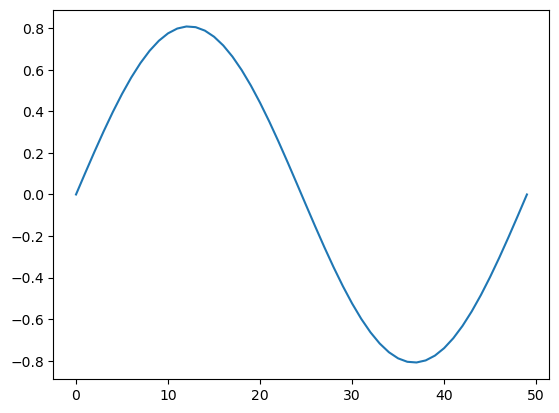

In [54]:
# Parameters
L = 1.0  # Length of the domain
nx = 50  # Number of spatial points

# Discretization
x = torch.from_numpy(np.linspace(0, L, nx,dtype=np.float64))
dx = x[1]-x[0]
dt = 0.25*dx

Dx = FiniteDifferenceOperator(1,1,dx)  # Finite difference operator w a neighbor on either side
def getData(x,k):
  return 1+1.*torch.sin(2.*np.pi*x)
u = getData(x,1.0)

plt.plot(Dx(u).detach().numpy()/(4.*np.pi**2))
plt.show()

**Generate training data**

Either using simulated data, by solving numerically

Or by applying an analytic solution to evaluate training data

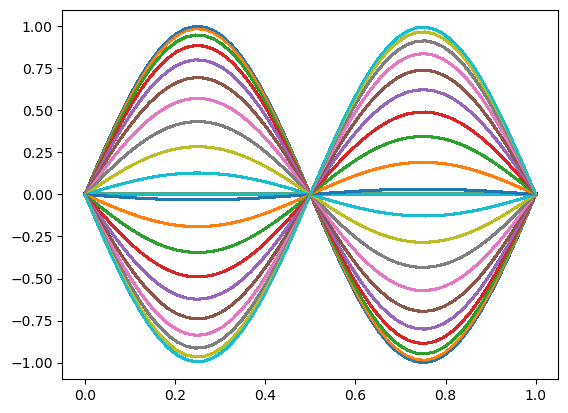

In [43]:
# Parameters
c = 1
# Parameters
L = 1.0  # Length of the domain
nx = 50  # Number of spatial points

# Discretization
x = torch.from_numpy(np.linspace(0, L, nx,dtype=np.float64))
dx = x[1]-x[0]
dt = 0.25*dx

# Discretization
T = 2.0  # Total time for training data
nt = int(T/dt)  # Number of time steps
t = np.linspace(0, T, nt+1)

def f(x):
    #Initial condition
    return 0.5*np.sin(2.*np.pi*x/L)
q = np.zeros((nt,nx))
p = np.zeros((nt,nx))
for i in range(nt):
    fl = f(x-c*t[i])
    fr = f(x+c*t[i])
    q[i,:] = (fl+fr)
    for i in range(20):
        plt.plot(x,q[5*i,:])
plt.show()


**Train the model**

In [44]:
# list trainable parameters in Dx
for name, param in Dx.named_parameters():
    print(name, param)

stencil1 Parameter containing:
tensor([ 0.9000, -0.9000], dtype=torch.float64, requires_grad=True)


In [56]:
Dx = FiniteDifferenceOperator(1,1,dx)  # Finite difference operator w a neighbor on either side
batchsize = 2
optimizer = optim.Adam(Dx.parameters(), lr=1e-4)
losslog = []

# Generate loss function comparison predicted timestep to actual timestep
for epoch in range(1000):
    # Clear the gradients
    optimizer.zero_grad()

    # choose a random subtrajectory of batchsize length
    start = np.random.randint(0, len(t)-batchsize)
    end = start + batchsize
    tbatch = t[start:end]
    qbatch = torch.from_numpy(q[start:end]).to(torch.float64)
    pbatch = torch.from_numpy(p[start:end]).to(torch.float64)

    # Evaluate current solution using the data-driven model
    solq = torch.zeros_like(qbatch)
    solp = torch.zeros_like(pbatch)
    solq[0, :] = qbatch[0, :]
    solp[0, :] = pbatch[0, :]
    
    #Integrate model over minibatch using Verlet scheme
    for step in range(1, len(tbatch)):
        qold = solq[step-1,:]
        pold = solp[step-1,:]
        
        # Verlet step 1: pnplushalf = pn - k/2 partial_q V(qn)
        partialqV = Dx(qold)
        pnplushalf = pold - 0.5 * dt *  partialqV 

        # Verlet step 2: qnplusone = qn + k partial_p T(pnplushalf)
        partialpT = pnplushalf
        qnplusone = qold + dt * partialpT

        # Verlet step 3: pnplusone = pnplushalf - k/2 partial_q V(qnplusone)
        partialqV = Dx(qnplusone)
        pnplusone = pnplushalf - 0.5 * dt *  partialqV

        # Save solution
        solq[step, :] = qnplusone
        solp[step, :] = pnplusone


    # Compute loss
    loss = (solq - torch.tensor(qbatch, dtype=torch.float64)).pow(2).sum() + (solp - torch.tensor(pbatch, dtype=torch.float64)).pow(2).sum()
    lossrel = loss/(solq.pow(2).sum() + solp.pow(2).sum())
    losslog.append(lossrel.item())
    print('Epoch:', epoch, 'Loss:', loss.item(), 'Relative Loss:', lossrel.item())
    loss.backward()
    optimizer.step()
        

C:\Users\nattr\AppData\Local\Temp\ipykernel_57876\1565462441.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = (solq - torch.tensor(qbatch, dtype=torch.float64)).pow(2).sum() + (solp - torch.tensor(pbatch, dtype=torch.float64)).pow(2).sum()


Epoch: 0 Loss: 0.6191122275778554 Relative Loss: 0.013124491503923797
Epoch: 1 Loss: 0.05607876415989854 Relative Loss: 0.022819955833145826
Epoch: 2 Loss: 0.15880215108439372 Relative Loss: 0.014956125920434899
Epoch: 3 Loss: 0.6398503393371759 Relative Loss: 0.013106811567350926
Epoch: 4 Loss: 0.14287357558681343 Relative Loss: 0.015291964414690747
Epoch: 5 Loss: 0.6475137885737365 Relative Loss: 0.013100672182460254
Epoch: 6 Loss: 0.025805983100160596 Relative Loss: 0.5061505363851672
Epoch: 7 Loss: 0.11311988008797598 Relative Loss: 0.016185133556499295
Epoch: 8 Loss: 0.04111126739201532 Relative Loss: 0.03252024255890243
Epoch: 9 Loss: 0.0871731382787904 Relative Loss: 0.017689735327043116
Epoch: 10 Loss: 0.6500889371306046 Relative Loss: 0.013098781233528629
Epoch: 11 Loss: 0.547639015777362 Relative Loss: 0.013196782814872297
Epoch: 12 Loss: 0.5164557248545909 Relative Loss: 0.0132384285226569
Epoch: 13 Loss: 0.5163292933680561 Relative Loss: 0.013235187675248424
Epoch: 14 Loss:

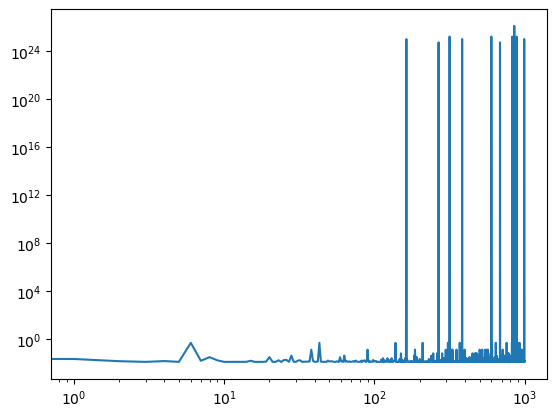

In [57]:
plt.figure()
plt.loglog(losslog)
plt.show()

In [58]:
print(Dx.stencil)

tensor([ 0.9000, -0.9000, -0.0000], dtype=torch.float64,
       grad_fn=<CatBackward0>)


In [59]:
# Roll out learned model
nrollout = 2
tro = np.linspace(0, nrollout*T, nrollout*nt+1)

qdata = torch.from_numpy(q).to(torch.float64)
pdata = torch.from_numpy(p).to(torch.float64)
solq = torch.zeros((nrollout*nt+1,nx)).to(torch.float64)
solp = torch.zeros((nrollout*nt+1,nx)).to(torch.float64)
solq[0, :] = qdata[0,:]
solp[0, :] = pdata[0,:]
for step in range(1, len(tro)):
    if step%50==0:
        print('Step:', step)
    qold = solq[step-1,:]
    pold = solp[step-1,:]
    
    # Verlet step 1: pnplushalf = pn - k/2 partial_q V(qn)
    partialqV = Dx(qold)
    pnplushalf = pold - 0.5 * dt * partialqV 

    # Verlet step 2: qnplusone = qn + k partial_p T(pnplushalf)
    partialpT = pnplushalf
    qnplusone = qold + dt * partialpT

    # Verlet step 3: pnplusone = pnplushalf - k/2 partial_q V(qnplusone)
    partialqV = Dx(qnplusone)
    pnplusone = pnplushalf - 0.5 * dt * partialqV

    # Save solution
    solq[step, :] = qnplusone
    solp[step, :] = pnplusone

Step: 50
Step: 100
Step: 150
Step: 200
Step: 250
Step: 300
Step: 350
Step: 400
Step: 450
Step: 500
Step: 550
Step: 600
Step: 650
Step: 700
Step: 750


In [60]:
print(Dx.stencil)
solq.shape

tensor([ 0.9000, -0.9000, -0.0000], dtype=torch.float64,
       grad_fn=<CatBackward0>)


torch.Size([785, 50])

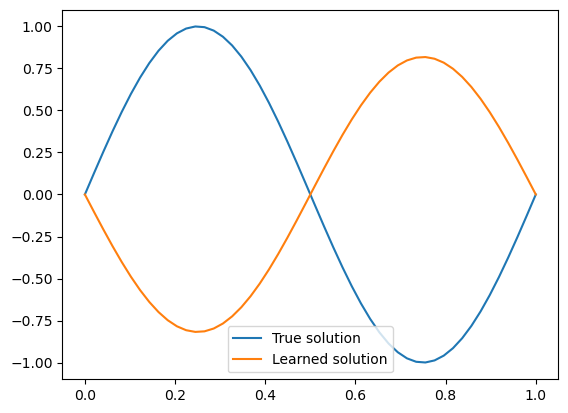

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [61]:
# Plot the results
plt.figure()
# plt.plot(x, q[0, :], label='Initial condition')
plt.plot(x, q[-1, :], label='True solution')
plt.plot(x, solq[-1, :].detach().numpy(), label='Learned solution')
# plt.plot(x, np.abs(q[1,:]-solq[1, :].detach().numpy()), label='Error')
plt.legend()
plt.show()
plt.figure()

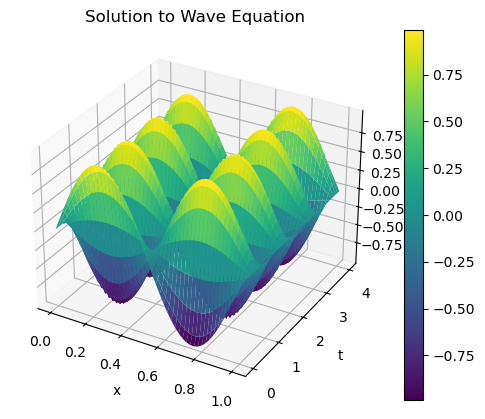

In [62]:
# %% Visualize solution in spacetime as a 3D plot
XX, TT = np.meshgrid(x, tro)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(XX, TT, solq.detach().numpy(), cmap='viridis')
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('q')
fig.colorbar(surf)
plt.title('Solution to Wave Equation')
plt.show()

In [363]:
plt.figure()
plt.show()

<Figure size 640x480 with 0 Axes>

## Alternative code to generate data numerically 

In [ ]:
# Parameters
c = 1.0  # Wave speed

# Discretization
T = 30.0  # Total time for training data
nt = int(T/dt)  # Number of time steps
t = np.linspace(0, T, nt+1)

# Solution arrays
q = np.zeros((nt, nx))
p = np.zeros((nt, nx))
# Initial condition
q[0, :] = np.exp(-100 * (x - 0.5*L)**2)
p[0, :] = 0.0

# Time-stepping loop using Verlet scheme
for n in range(nt-1):
    if n%50==0:
        print('Step:', n)
    # Recall H = \sum_i 0.5 * p_i**2 h**-1 + 0.5 (D-q)_i**2 h

    # Verlet step 1: pnplushalf = pn - k/2 partial_q V(qn)
    partialqV = np.zeros_like(q[n, :])
    for i in range(nx):
        partialqV[i] = dx* (-c**2 / dx**2) * (q[n, (i + 1)%(nx-1)] - 2 * q[n, i] + q[n, (i - 1)%(nx-1)])
    pnplushalf = p[n, :] - 0.5 * dt * partialqV 

    # Verlet step 2: qnplusone = qn + k partial_p T(pnplushalf)
    partialpT = pnplushalf
    q[n + 1, :] = q[n,:] + dt * partialpT

    # Verlet step 3: pnplusone = pnplushalf - k/2 partial_q V(qnplusone)
    partialqV = np.zeros_like(q[n, :])
    for i in range(nx):
        partialqV[i] = dx*(-c**2 / dx**2) * (q[n + 1, (i + 1)%(nx-1)] - 2 * q[n + 1, i] + q[n + 1, (i - 1)%(nx-1)])
    p[n + 1, :] = pnplushalf - 0.5 * dt * partialqV

